In [124]:
!pip install catboost

In [125]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [126]:
data = pd.read_csv("/content/application_record.csv", encoding = 'utf-8')
record = pd.read_csv("/content/credit_record.csv", encoding = 'utf-8')

In [127]:
plt.rcParams['figure.facecolor'] = 'white'

# Feature Engineering

## Response Variable

In [128]:
# find all users' account open month.
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'})
new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data

Generally, users in risk should be in 3%, thus I choose users who overdue for more than 60 days as target risk users. Those samples are marked as '1', else are '0'.

In [129]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='2']='Yes'
record['dep_value'][record['STATUS'] =='3']='Yes'
record['dep_value'][record['STATUS'] =='4']='Yes'
record['dep_value'][record['STATUS'] =='5']='Yes'

In [130]:
cpunt=record.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0

In [131]:
print(cpunt['dep_value'].value_counts())
cpunt['dep_value'].value_counts(normalize=True)

dep_value
No     45318
Yes      667
Name: count, dtype: int64


,proportion
dep_value,
No,0.985495
Yes,0.014505


## Features

+ rename

In [132]:
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)

In [133]:
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna()

In [134]:
ivtable=pd.DataFrame(new_data.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['FLAG_MOBIL','begin_month','dep_value','target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

+ Define `calc_iv` function to [calculate](https://www.kaggle.com/puremath86/iv-woe-starter-for-python) Information Value and WOE Value

### Binary Features

In [135]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    print(df[feature].value_counts())
    return iv, data

In [136]:
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [137]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut

    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [138]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Gender

In [139]:
new_data['Gender'] = new_data['Gender'].replace(['F','M'],[0,1])
print(new_data['Gender'].value_counts())
iv, data = calc_iv(new_data,'Gender','target')
ivtable.loc[ivtable['variable']=='Gender','IV']=iv
data.head()

Gender
0    15630
1     9504
Name: count, dtype: int64
This variable's IV is: 0.02520350452745081
Gender
0    15630
1     9504
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Gender,0,15630,15400,230,0.621867,0.014715,0.623179,0.545024,0.134005,0.010473
1,Gender,1,9504,9312,192,0.378133,0.020202,0.376821,0.454976,-0.188475,0.014730


#### Having a car or not

In [140]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
data.head()

Car
0    14618
1    10516
Name: count, dtype: int64
This variable's IV is: 4.54248124999671e-06
Car
0    14618
1    10516
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Car,0,14618,14373,245,0.581603,0.016760,0.58162,0.580569,0.00181,0.000002
1,Car,1,10516,10339,177,0.418397,0.016831,0.41838,0.419431,-0.00251,0.000003


#### Having house reality or not

In [141]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])
print(new_data['Reality'].value_counts())
iv, data=calc_iv(new_data,'Reality','target')
ivtable.loc[ivtable['variable']=='Reality','IV']=iv
data.head()

Reality
1    16461
0     8673
Name: count, dtype: int64
This variable's IV is: 0.02744070350168343
Reality
1    16461
0     8673
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Reality,0,8673,8494,179,0.34507,0.020639,0.34372,0.424171,-0.210309,0.016920
1,Reality,1,16461,16218,243,0.65493,0.014762,0.65628,0.575829,0.130777,0.010521


#### Having a phone or not

In [142]:
new_data['phone']=new_data['phone'].astype(str)
print(new_data['phone'].value_counts(normalize=True,sort=False))
new_data.drop(new_data[new_data['phone'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'phone','target')
ivtable.loc[ivtable['variable']=='phone','IV']=iv
data.head()

phone
0    0.707209
1    0.292791
Name: proportion, dtype: float64
This variable's IV is: 0.0005480495762639297
phone
0    17775
1     7359
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,phone,0,17775,17481,294,0.707209,0.016540,0.707389,0.696682,0.015251,0.000163
1,phone,1,7359,7231,128,0.292791,0.017394,0.292611,0.303318,-0.035937,0.000385


#### Having an email or not

In [143]:
print(new_data['email'].value_counts(normalize=True,sort=False))
new_data['email']=new_data['email'].astype(str)
iv, data=calc_iv(new_data,'email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
data.head()

email
0    0.89934
1    0.10066
Name: proportion, dtype: float64
This variable's IV is: 1.7343581493999816e-05
email
0    22604
1     2530
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,email,0,22604,22225,379,0.89934,0.016767,0.899361,0.898104,0.001398,0.000002
1,email,1,2530,2487,43,0.10066,0.016996,0.100639,0.101896,-0.012407,0.000016


#### Having a Work Phone or not

In [144]:
new_data['wkphone']=new_data['wkphone'].astype(str)
iv, data = calc_iv(new_data,'wkphone','target')
new_data.drop(new_data[new_data['wkphone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='wkphone','IV']=iv
data.head()

This variable's IV is: 0.002042429795148461
wkphone
0    18252
1     6882
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,wkphone,0,18252,17954,298,0.726188,0.016327,0.72653,0.706161,0.028436,0.000579
1,wkphone,1,6882,6758,124,0.273812,0.018018,0.27347,0.293839,-0.071838,0.001463


### Continuous Variables

#### Children Numbers

In [145]:
new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2More'
print(new_data['ChldNo'].value_counts(sort=False))

ChldNo
0        15908
2More     3108
1         6118
Name: count, dtype: int64


In [146]:
iv, data=calc_iv(new_data,'ChldNo','target')
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv
data.head()

This variable's IV is: 0.0011214542503301935
ChldNo
0        15908
1         6118
2More     3108
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ChldNo,0,15908,15635,273,0.632928,0.017161,0.632689,0.646919,-0.022243,0.000317
1,ChldNo,1,6118,6021,97,0.243415,0.015855,0.243647,0.229858,0.058259,0.000803
2,ChldNo,2More,3108,3056,52,0.123657,0.016731,0.123665,0.123223,0.003580,0.000002


In [147]:
new_data = convert_dummy(new_data,'ChldNo')

#### Annual Income
bins the data based on sample quantiles

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

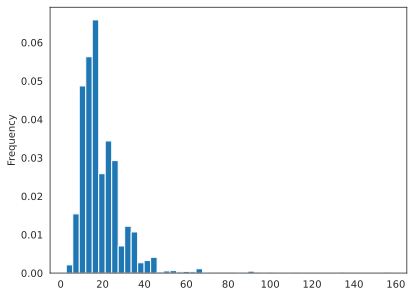

In [148]:
new_data['inc']=new_data['inc'].astype(object)
new_data['inc'] = new_data['inc']/10000
print(new_data['inc'].value_counts(bins=10,sort=False))
new_data['inc'].plot(kind='hist',bins=50,density=True)

In [149]:
new_data = get_category(new_data,'inc', 3, ["low","medium", "high"], qcut = True)
iv, data = calc_iv(new_data,'gp_inc','target')
ivtable.loc[ivtable['variable']=='inc','IV']=iv
data.head()

This variable's IV is: 0.0024219962221596752
gp_inc
low       8996
high      8244
medium    7894
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_inc,high,8244,8096,148,0.328002,0.017952,0.327614,0.350711,-0.068126,0.001573
1,gp_inc,low,8996,8849,147,0.357922,0.016341,0.358085,0.348341,0.027588,0.000269
2,gp_inc,medium,7894,7767,127,0.314077,0.016088,0.314301,0.300948,0.043413,0.000580


In [150]:
new_data = convert_dummy(new_data,'gp_inc')

#### Age
Bucketing Continuous Variables

(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: proportion, dtype: float64


<Axes: ylabel='Frequency'>

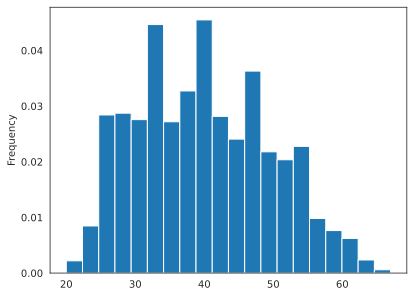

In [151]:
new_data['Age']=-(new_data['DAYS_BIRTH'])//365
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))
new_data['Age'].plot(kind='hist',bins=20,density=True)

In [152]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

This variable's IV is: 0.06593513858884348
gp_Age
medium     7916
low        7806
high       4414
lowest     4005
highest     993
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_Age,high,4414,4323,91,0.175619,0.020616,0.174935,0.215640,-0.209194,0.008515
1,gp_Age,highest,993,989,4,0.039508,0.004028,0.040021,0.009479,1.440361,0.043992
2,gp_Age,low,7806,7686,120,0.310575,0.015373,0.311023,0.284360,0.089625,0.002390
3,gp_Age,lowest,4005,3921,84,0.159346,0.020974,0.158668,0.199052,-0.226754,0.009157
4,gp_Age,medium,7916,7793,123,0.314952,0.015538,0.315353,0.291469,0.078758,0.001881


In [153]:
new_data = convert_dummy(new_data,'gp_Age')

#### Working Years
+ Equal-length Bucketing

<Axes: ylabel='Frequency'>

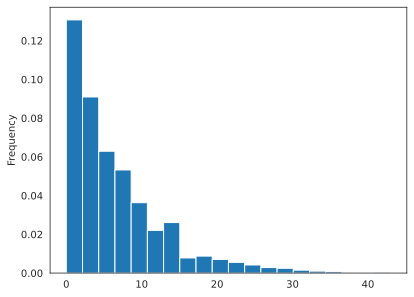

In [154]:
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365
new_data[new_data['worktm']<0] = np.nan # replace by na
new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) #replace na by mean
new_data['worktm'].plot(kind='hist',bins=20,density=True)

In [155]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

This variable's IV is: 0.04022152230816303
gp_worktm
lowest     18254
low         4987
medium      1378
high         425
highest       90
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_worktm,high,425,423,2,0.016909,0.004706,0.017117,0.004739,1.284186,0.015895
1,gp_worktm,highest,90,90,0,0.003581,0.000000,0.003642,0.000000,0.000000,0.000000
2,gp_worktm,low,4987,4921,66,0.198416,0.013234,0.199134,0.156398,0.241573,0.010324
3,gp_worktm,lowest,18254,17916,338,0.726267,0.018516,0.724992,0.800948,-0.099635,0.007568
4,gp_worktm,medium,1378,1362,16,0.054826,0.011611,0.055115,0.037915,0.374082,0.006434


In [156]:
new_data = convert_dummy(new_data,'gp_worktm')

#### Famliy Size

In [157]:
new_data['famsize'].value_counts(sort=False)

,count
famsize,
2.0,12697
1.0,4263
5.0,307
3.0,5216
4.0,2576
6.0,51
15.0,3
7.0,18
20.0,1


In [158]:
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target')
ivtable.loc[ivtable['variable']=='famsize','IV']=iv
data.head()

This variable's IV is: 0.006156138510778323
famsizegp
2        12697
3more     8174
1         4263
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famsizegp,1,4263,4179,84,0.169611,0.019704,0.169108,0.199052,-0.163028,0.004882
1,famsizegp,2,12697,12489,208,0.505172,0.016382,0.505382,0.492891,0.025027,0.000313
2,famsizegp,3more,8174,8044,130,0.325217,0.015904,0.325510,0.308057,0.055108,0.000962


In [159]:
new_data = convert_dummy(new_data,'famsizegp')

### Categorical Features

#### Income Type

In [160]:
print(new_data['inctp'].value_counts(sort=False))
print(new_data['inctp'].value_counts(normalize=True,sort=False))
new_data.loc[new_data['inctp']=='Pensioner','inctp']='State servant'
new_data.loc[new_data['inctp']=='Student','inctp']='State servant'
iv, data=calc_iv(new_data,'inctp','target')
ivtable.loc[ivtable['variable']=='inctp','IV']=iv
data.head()

inctp
Working                 15622
Commercial associate     7052
State servant            2437
Student                    10
Pensioner                  13
Name: count, dtype: int64
inctp
Working                 0.621549
Commercial associate    0.280576
State servant           0.096960
Student                 0.000398
Pensioner               0.000517
Name: proportion, dtype: float64
This variable's IV is: 5.159303327851404e-05
inctp
Working                 15622
Commercial associate     7052
State servant            2460
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,inctp,Commercial associate,7052,6933,119,0.280576,0.016875,0.280552,0.281991,-0.005115,0.000007
1,inctp,State servant,2460,2418,42,0.097875,0.017073,0.097847,0.099526,-0.017013,0.000029
2,inctp,Working,15622,15361,261,0.621549,0.016707,0.621601,0.618483,0.005028,0.000016


In [161]:
new_data = convert_dummy(new_data,'inctp')

#### Occupation Type

In [162]:
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'
print(new_data['occyp'].value_counts())
iv, data=calc_iv(new_data,'occyp','target')
ivtable.loc[ivtable['variable']=='occyp','IV']=iv
data.head()

occyp
Laborwk      10496
officewk     10183
hightecwk     4455
Name: count, dtype: int64
This variable's IV is: 0.004820472062853304
occyp
Laborwk      10496
officewk     10183
hightecwk     4455
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,occyp,Laborwk,10496,10311,185,0.417602,0.017626,0.417247,0.438389,-0.049428,0.001045
1,occyp,hightecwk,4455,4375,80,0.177250,0.017957,0.177039,0.189573,-0.068404,0.000857
2,occyp,officewk,10183,10026,157,0.405148,0.015418,0.405714,0.372038,0.086652,0.002918


In [163]:
new_data = convert_dummy(new_data,'occyp')

#### House Type

In [164]:
iv, data=calc_iv(new_data,'houtp','target')
ivtable.loc[ivtable['variable']=='houtp','IV']=iv
data.head()

This variable's IV is: 0.0073275026880227365
houtp
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,houtp,Co-op apartment,152,149,3,0.006048,0.019737,0.006029,0.007109,-0.164705,0.000178
1,houtp,House / apartment,22102,21738,364,0.879367,0.016469,0.879654,0.862559,0.019624,0.000335
2,houtp,Municipal apartment,812,793,19,0.032307,0.023399,0.032090,0.045024,-0.338655,0.004380
3,houtp,Office apartment,199,194,5,0.007918,0.025126,0.007850,0.011848,-0.411619,0.001646
4,houtp,Rented apartment,439,433,6,0.017466,0.013667,0.017522,0.014218,0.208939,0.000690


In [165]:
new_data = convert_dummy(new_data,'houtp')

#### Education

In [166]:
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()

This variable's IV is: 0.010361794017679489
edutp
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,edutp,Higher education,7146,7018,128,0.284316,0.017912,0.283992,0.303318,-0.065836,0.001272
1,edutp,Incomplete higher,993,972,21,0.039508,0.021148,0.039333,0.049763,-0.235206,0.002453
2,edutp,Lower secondary,187,181,6,0.007440,0.032086,0.007324,0.014218,-0.663301,0.004573
3,edutp,Secondary / secondary special,16808,16541,267,0.668736,0.015885,0.669351,0.632701,0.056310,0.002064


In [167]:
new_data = convert_dummy(new_data,'edutp')

####  Marriage Condition

In [168]:
new_data['famtp'].value_counts(normalize=True,sort=False)

,proportion
famtp,
Married,0.696626
Single / not married,0.137065
Civil marriage,0.084865
Separated,0.058367
Widow,0.023076


In [169]:
iv, data=calc_iv(new_data,'famtp','target')
ivtable.loc[ivtable['variable']=='famtp','IV']=iv
data.head()

This variable's IV is: 0.043137115423127946
famtp
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famtp,Civil marriage,2133,2101,32,0.084865,0.015002,0.085019,0.075829,0.114394,0.001051
1,famtp,Married,17509,17232,277,0.696626,0.015820,0.697313,0.656398,0.060467,0.002474
2,famtp,Separated,1467,1452,15,0.058367,0.010225,0.058757,0.035545,0.502608,0.011666
3,famtp,Single / not married,3445,3362,83,0.137065,0.024093,0.136047,0.196682,-0.368588,0.022349
4,famtp,Widow,580,565,15,0.023076,0.025862,0.022863,0.035545,-0.441263,0.005596


In [170]:
new_data = convert_dummy(new_data,'famtp')

## IV、WOE：Concept and Application

Weight of Evidence(WoE):  

$$wo{e_i} = \ln {{{P_{yi}}} \over {{P_{ni}}}} = \ln {{{y_i}/{y_s}} \over {{n_i}/{n_s}}}$$
$wo{e_i}$ is the I category's WOE value. ${{P_{yi}}}$ is the proportion of the positive samples in this category to all positive samples.   ${{P_{ni}}}$ is the ratio of negative samples (${{n_i}}$) in this class to all negative samples (${{n_s}}$).

Information Value (IV):  
$$I{V_i} = ({P_{yi}} - {P_{ni}}) \times wo{e_i}$$  
The IV values of the various types are the difference between the conditional positive rate and the conditional negative rate multiplied by the WOE value of the variable. The total IV value of the variable can be understood as the weighted sum of the conditional positive rate and the conditional negative rate difference:
$$IV = \sum\limits_i^n {I{V_i}} $$  

The IV value measures the variable's ability to predict.


Relationship between IV value and predictive power

| IV| Ability to predict |
|:------|:------:|
| <0.02 | Almost no predictive power |
|0.02~0.1 |weak predictive power|
|0.1~0.3|Moderate predictive power|
|0.3~0.5|Strong predictive power|
|>0.5|Predictive power is too strong, need to check variables|

In [171]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

,variable,IV
10,agegp,0.065935
8,famtp,0.043137
11,worktmgp,0.040222
3,Reality,0.027441
1,Gender,0.025204
7,edutp,0.010362
9,houtp,0.007328
17,famsize,0.006156
16,occyp,0.00482
5,incgp,0.002422


No charts were generated by quickchart


# Algorithms

+ Split Dataset

In [172]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize', 'begin_month',
       'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high',
       'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest', 'worktm', 'gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

In [173]:
Y = new_data['target']
X = new_data[['Gender','Reality','ChldNo_1', 'ChldNo_2More','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk',
              'occyp_officewk','famsizegp_1', 'famsizegp_3more',
       'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents','edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
       'famtp_Separated','famtp_Single / not married','famtp_Widow']]

+ Using Synthetic Minority Over-Sampling Technique(`SMOTE`) to overcome sample imbalance problem.

In [174]:
Y = Y.astype('int')
X_balance,Y_balance = SMOTE().fit_resample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

+ After over sampling, the number between 1 and 0 is balanced. It can be seen from the confusion matrix.

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance,
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

## Logistic Regression   

$$\log ({p \over {1 - p}}) = {\beta _0} + {\beta _1}{x_1} +  \cdot  \cdot  \cdot  + {\beta _q}{x_q}$$

Accuracy Score is 0.59597
      0     1
0  4343  3071
1  2920  4494
[[0.58578365 0.41421635]
 [0.39384947 0.60615053]]


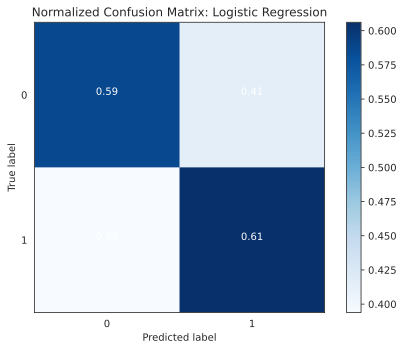

In [176]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white')
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True,
                      title='Normalized Confusion Matrix: Logistic Regression')


## Decision Tree

In [177]:
model = DecisionTreeClassifier(max_depth=12,
                               min_samples_split=8,
                               random_state=1024)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True,
                      title='Normalized Confusion Matrix: CART')

## Random Forest   





In [178]:
model = RandomForestClassifier(n_estimators=250,
                              max_depth=12,
                              min_samples_leaf=16
                              )
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True,
                      title='Normalized Confusion Matrix: Ramdom Forests')

## SVM




In [179]:
model = svm.SVC(C = 0.8,
                kernel='linear')
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True,
                      title='Normalized Confusion Matrix: SVM')

## LightGBM

In [180]:
# Convert wkphone column to integer before passing to LightGBM
X_train['wkphone'] = X_train['wkphone'].astype(int)
X_test['wkphone'] = X_test['wkphone'].astype(int)

model = LGBMClassifier(num_leaves=31,
                       max_depth=8,
                       learning_rate=0.02,
                       n_estimators=250,
                       subsample = 0.8,
                       colsample_bytree =0.8
                      )
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

Showing important features:

In [181]:
def plot_importance(classifer, x_train, point_size = 25):
    '''plot feature importance'''
    values = sorted(zip(x_train.columns, classifer.feature_importances_), key = lambda x: x[1] * -1)
    imp = pd.DataFrame(values,columns = ["Name", "Score"])
    imp.sort_values(by = 'Score',inplace = True)
    sns.scatterplot(x = 'Score',y='Name', linewidth = 0,
                data = imp,s = point_size, color='red').set(
    xlabel='importance',
    ylabel='features')

plot_importance(model, X_train,20)

In [182]:
model.booster_.feature_importance(importance_type='gain')

## Xgboost

In [183]:
model = XGBClassifier(max_depth=12,
                      n_estimators=250,
                      min_child_weight=8,
                      subsample=0.8,
                      learning_rate =0.02,
                      seed=42)

model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

In [184]:
plot_importance(model, X_train, 20)

## CatBoost

In [185]:
model = CatBoostClassifier(iterations=250,
                           learning_rate=0.2,
                           od_type='Iter',
                           verbose=25,
                           depth=16,
                           random_seed=42)

model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('CatBoost Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

In [187]:
# Final feature list used for logistic regression
features = X.columns.tolist()

# Group features by base feature (remove dummy prefixes)
from collections import defaultdict
import re

feature_bins = defaultdict(list)

for feat in features:
    # extract the base name (e.g. 'gp_Age_low' → 'gp_Age')
    base = re.split(r'_[^_]+$', feat)[0] if '_' in feat else feat
    feature_bins[base].append(feat)

# Print each base feature and its bin variants
print("Feature and their Bins:\n")
for base, bins in feature_bins.items():
    print(f"{base}: {bins}")


Feature and their Bins:

Gender: ['Gender']
Reality: ['Reality']
ChldNo: ['ChldNo_1', 'ChldNo_2More']
wkphone: ['wkphone']
gp_Age: ['gp_Age_high', 'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest']
gp_worktm: ['gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium']
occyp: ['occyp_hightecwk', 'occyp_officewk']
famsizegp: ['famsizegp_1', 'famsizegp_3more']
houtp: ['houtp_Co-op apartment', 'houtp_Municipal apartment', 'houtp_Office apartment', 'houtp_Rented apartment', 'houtp_With parents']
edutp: ['edutp_Higher education', 'edutp_Incomplete higher', 'edutp_Lower secondary']
famtp: ['famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married', 'famtp_Widow']


In [194]:
import pandas as pd
import io, contextlib
from sklearn.linear_model import LogisticRegression

# 1. (Re)train the logistic model if needed
log_model = LogisticRegression(C=0.8, random_state=0, solver='lbfgs')
log_model.fit(X_train, y_train)
new_data['Gender'] = new_data['Gender'].replace(['F','M'], [0,1])
buf = io.StringIO()
with contextlib.redirect_stdout(buf):
    iv_gender, woe_gender = calc_iv(new_data, 'Gender', 'target', pr=False)
beta_gender = log_model.coef_[0][ X.columns.get_loc('Gender') ]

print("Gender")
print(f"IV = {iv_gender:.4f}")
print(f"β (coefficient) = {beta_gender:.4f}\n")

table = woe_gender[['Value','All','Good','Bad','WoE','IV']].copy()
table.columns = ['Gender','Total','Good','Bad','WoE','IV']

print(table.to_string(index=False,
                      formatters={
                        'Gender': '{:>6}'.format,
                        'Total':  '{:>6}'.format,
                        'Good':   '{:>6}'.format,
                        'Bad':    '{:>6}'.format,
                        'WoE':    '{:>9.6f}'.format,
                        'IV':     '{:>9.6f}'.format
                      }))


Gender
IV = 0.0252
β (coefficient) = 0.1544

Gender  Total   Good    Bad       WoE        IV
     0  15630  15400    230  0.134005  0.010473
     1   9504   9312    192 -0.188475  0.014730


In [202]:
import numpy as np
import pandas as pd
import io, contextlib
from sklearn.linear_model import LogisticRegression

# --- 1) Retrain or load your logistic model ---
log_model = LogisticRegression(C=0.8, random_state=0, solver='lbfgs')
log_model.fit(X_train_woe, y_train_woe)

# --- 2) Parameters from the slide ---
PDO = 20
Factor = PDO / np.log(2)             # ≈ 28.85
BaseScore = 600
BaseOdds = 50
Offset = BaseScore - Factor * np.log(BaseOdds)

# --- 3) Formula constants ---
alpha = log_model.intercept_[0]
features = X_train_woe.columns.tolist()
N = len(features)

# --- 4) Helper to compute per-feature table ---
def make_score_table(feat_name, woe_table):
    # extract β for this WoE feature
    beta = log_model.coef_[0][ features.index(feat_name + '_WoE') ]

    # build table
    tbl = woe_table[['Value','All','Good','Bad','WoE','IV']].copy()
    tbl.columns = [feat_name, 'Total','Good','Bad','WoE','IV']

    # compute Score_i per bin
    tbl['Score'] = (
        (beta * tbl['WoE'] + alpha / N) * Factor
        + Offset / N
    ).round(2)

    # print header
    print(f"{feat_name} (WoE)")
    iv = woe_table['IV'].sum()
    print(f"IV = {iv:.4f}")
    print(f"α (intercept) = {alpha:.4f}, N = {N}")
    print(f"β (coef for {feat_name}_WoE) = {beta:.4f}\n")

    # display
    print(tbl.to_string(index=False,
        formatters={
            feat_name: '{:>8}'.format,
            'Total':    '{:>6}'.format,
            'Good':     '{:>6}'.format,
            'Bad':      '{:>6}'.format,
            'WoE':      '{:>9.6f}'.format,
            'IV':       '{:>9.6f}'.format,
            'Score':    '{:>9.2f}'.format
        }))
    print("\n" + "="*60 + "\n")

# --- 5) Compute and print for Gender & Car ---
#    (Assumes you have woe_gender_table & woe_car_table from calc_iv)
make_score_table('Gender', woe_gender_table)
make_score_table('Car',    woe_car_table)


Gender (WoE)
IV = 0.0252
α (intercept) = -0.0147, N = 16
β (coef for Gender_WoE) = -0.6215

  Gender  Total   Good    Bad       WoE        IV     Score
       0  15630  15400    230  0.134005  0.010473     28.02
       1   9504   9312    192 -0.188475  0.014730     33.80


Car (WoE)
IV = 0.0000
α (intercept) = -0.0147, N = 16
β (coef for Car_WoE) = 0.0864

     Car  Total   Good    Bad       WoE        IV     Score
       0  14618  14373    245  0.001810  0.000002     30.42
       1  10516  10339    177 -0.002510  0.000003     30.41




In [203]:
import numpy as np
import pandas as pd
import io, contextlib
from sklearn.linear_model import LogisticRegression

# --- 1) (Re)train the logistic model on your WoE-transformed X/Y if not yet done ---
log_model = LogisticRegression(C=0.8, random_state=0, solver='lbfgs')
log_model.fit(X_train_woe, y_train_woe)

# --- 2) Slide parameters ---
PDO = 20
Factor = PDO / np.log(2)             # ≈ 28.85
BaseScore = 600
BaseOdds = 50
Offset = BaseScore - Factor * np.log(BaseOdds)

# --- 3) Common constants ---
alpha = log_model.intercept_[0]
features = X_train_woe.columns.tolist()
N = len(features)

# --- 4) Helper to print one feature's score table ---
def make_score_table(feat_col, raw_feature_name, woe_table):
    """
    feat_col:   the column in X_train_woe (e.g. 'Reality_WoE')
    raw_feature_name:  for display & col lookup in woe_table (e.g. 'Reality')
    woe_table:  DataFrame returned by calc_iv(...)
    """
    # β for this feature
    beta = log_model.coef_[0][ features.index(feat_col) ]

    # Build display table
    tbl = woe_table[['Value','All','Good','Bad','WoE','IV']].copy()
    tbl.columns = [raw_feature_name, 'Total','Good','Bad','WoE','IV']

    # Compute score per bin
    tbl['Score'] = (
        (beta * tbl['WoE'] + alpha / N) * Factor
        + Offset / N
    ).round(2)

    # Header
    iv_sum = tbl['IV'].sum()
    print(f"{raw_feature_name}")
    print(f"IV = {iv_sum:.4f}")
    print(f"α (intercept) = {alpha:.4f}, N = {N}")
    print(f"β (coef for {feat_col}) = {beta:.4f}\n")

    # Print table
    print(tbl.to_string(index=False,
        formatters={
            raw_feature_name: '{:>8}'.format,
            'Total':    '{:>6}'.format,
            'Good':     '{:>6}'.format,
            'Bad':      '{:>6}'.format,
            'WoE':      '{:>9.6f}'.format,
            'IV':       '{:>9.6f}'.format,
            'Score':    '{:>9.2f}'.format
        }))
    print("\n" + "="*60 + "\n")


# --- 5) Preprocess & calc_iv for each feature, then print ---
for feat, repl in [
    ('Reality',  (['N','Y'], [0,1])),
    ('phone',    (None,   None)),    # already binary 0/1 after as str→int
    ('email',    (None,   None)),
    ('wkphone',  (None,   None))
]:
    # a) Recode if needed
    if repl[0] is not None:
        new_data[feat] = new_data[feat].replace(*repl)
    # b) For phone/email, drop NaNs as before
    if feat in ('phone','wkphone'):
        new_data[feat] = new_data[feat].astype(str)
        new_data.drop(new_data[new_data[feat]=='nan'].index, inplace=True)
    if feat == 'email':
        new_data[feat] = new_data[feat].astype(str)

    # c) Capture IV & WoE without extra prints
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):
        iv_val, woe_tbl = calc_iv(new_data, feat, 'target', pr=False)

    # d) Call helper to print the score table
    make_score_table(feat + '_WoE' if feat!='Reality' else feat + '_WoE',
                     feat, woe_tbl)


Reality
IV = 0.0274
α (intercept) = -0.0147, N = 16
β (coef for Reality_WoE) = -0.8436

 Reality  Total   Good    Bad       WoE        IV     Score
       0   8673   8494    179 -0.210309  0.016920     35.54
       1  16461  16218    243  0.130777  0.010521     27.24


phone
IV = 0.0005
α (intercept) = -0.0147, N = 16
β (coef for phone_WoE) = 0.1971

   phone  Total   Good    Bad       WoE        IV     Score
       0  17775  17481    294  0.015251  0.000163     30.51
       1   7359   7231    128 -0.035937  0.000385     30.21


email
IV = 0.0000
α (intercept) = -0.0147, N = 16
β (coef for email_WoE) = 0.0569

   email  Total   Good    Bad       WoE        IV     Score
       0  22604  22225    379  0.001398  0.000002     30.42
       1   2530   2487     43 -0.012407  0.000016     30.40


wkphone
IV = 0.0020
α (intercept) = -0.0147, N = 16
β (coef for wkphone_WoE) = 0.9670

 wkphone  Total   Good    Bad       WoE        IV     Score
       0  18252  17954    298  0.028436  0.000579    

In [208]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# --- 1) Your supplied ChldNo table ---
chldno_tbl = pd.DataFrame([
    {'ChldNo': '0',      'Total': 15908, 'Good': 15635, 'Bad': 273, 'WoE': -0.022243, 'IV': 0.000317},
    {'ChldNo': '1',      'Total':  6118, 'Good':  6021, 'Bad':  97, 'WoE':  0.058259, 'IV': 0.000803},
    {'ChldNo': '2More',  'Total':  3108, 'Good':  3056, 'Bad':  52, 'WoE':  0.003580, 'IV': 0.000002},
])

# --- 2) Re-train (or load) your logistic model on the WoE features ---
#    Here we assume you have X_train_woe, y_train_woe ready
log_model = LogisticRegression(C=0.8, random_state=0, solver='lbfgs')
log_model.fit(X_train_woe, y_train_woe)

# --- 3) Extract intercept α and β for ChldNo_WoE ---
alpha = log_model.intercept_[0]
features = X_train_woe.columns.tolist()
beta_chld = log_model.coef_[0][ features.index('ChldNo_WoE') ]

# --- 4) Slide‐formula parameters ---
PDO = 20
Factor = PDO / np.log(2)        # ≈ 28.85
BaseScore = 600
BaseOdds  = 50
Offset    = BaseScore - Factor * np.log(BaseOdds)
N         = len(features)      # total # of WoE features

# --- 5) Compute per‐bin Score for ChldNo ---
chldno_tbl['Score'] = (
    (beta_chld * chldno_tbl['WoE'] + alpha / N) * Factor
    + Offset / N
).round(2)

# --- 6) Print results ---
print("ChldNo")
print(f"IV = {chldno_tbl['IV'].sum():.10f}")
print(f"α (intercept) = {alpha:.4f}, N = {N}")
print(f"β (coef for ChldNo_WoE) = {beta_chld:.4f}\n")

print(chldno_tbl.to_string(index=False,
    formatters={
      'ChldNo': '{:>6}'.format,
      'Total':  '{:>6}'.format,
      'Good':   '{:>6}'.format,
      'Bad':    '{:>6}'.format,
      'WoE':    '{:>9.6f}'.format,
      'IV':     '{:>9.6f}'.format,
      'Score':  '{:>9.2f}'.format
    }))



ChldNo
IV = 0.0011220000
α (intercept) = -0.0147, N = 16
β (coef for ChldNo_WoE) = -3.4863

ChldNo  Total   Good    Bad       WoE        IV     Score
     0  15908  15635    273 -0.022243  0.000317     32.66
     1   6118   6021     97  0.058259  0.000803     24.56
 2More   3108   3056     52  0.003580  0.000002     30.06


In [210]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# 1) Your supplied gp_inc table:
inc_tbl = pd.DataFrame([
    {'gp_inc': 'high',   'Total': 8244, 'Good': 8096, 'Bad': 148, 'WoE': -0.068126, 'IV': 0.001573},
    {'gp_inc': 'low',    'Total': 8996, 'Good': 8849, 'Bad': 147, 'WoE':  0.027588, 'IV': 0.000269},
    {'gp_inc': 'medium', 'Total': 7894, 'Good': 7767, 'Bad': 127, 'WoE':  0.043413, 'IV': 0.000580},
])

# 2) Train or load your WoE‐based logistic model
#    (Assumes X_train_woe, y_train_woe are already defined)
log_model = LogisticRegression(C=0.8, random_state=0, solver='lbfgs')
log_model.fit(X_train_woe, y_train_woe)

# 3) Grab α (intercept) and β for your income‐group WoE feature
alpha = log_model.intercept_[0]
features = X_train_woe.columns.tolist()

# IMPORTANT: inspect your actual column name in X_train_woe.
# For example:
# print(features)
# If you binned “inc” into “gp_inc” and then did get_category + convert_dummy,
# your column for WoE should be named "gp_inc_WoE".
# Adjust the string below to match exactly:
beta_inc = log_model.coef_[0][ features.index('gp_inc_WoE') ]

# 4) Scoring constants from your slide:
PDO      = 20
Factor   = PDO / np.log(2)   # ≈ 28.85
BaseScore= 600
BaseOdds = 50
Offset   = BaseScore - Factor * np.log(BaseOdds)
N        = len(features)

# 5) Compute the per‐bin scores
inc_tbl['Score'] = (
    (beta_inc * inc_tbl['WoE'] + alpha / N) * Factor
    + Offset / N
).round(2)

# 6) Print the results
print("gp_inc (Income Group)")
print(f"IV = {inc_tbl['IV'].sum():.10f}")
print(f"α (intercept) = {alpha:.4f}, N = {N}")
print(f"β (coef for gp_inc_WoE) = {beta_inc:.4f}\n")

print(inc_tbl.to_string(index=False,
    formatters={
      'gp_inc': '{:>8}'.format,
      'Total':  '{:>6}'.format,
      'Good':   '{:>6}'.format,
      'Bad':    '{:>6}'.format,
      'WoE':    '{:>9.6f}'.format,
      'IV':     '{:>9.6f}'.format,
      'Score':  '{:>9.2f}'.format
    }))


gp_inc (Income Group)
IV = 0.0024220000
α (intercept) = -0.0147, N = 16
β (coef for gp_inc_WoE) = -0.1809

  gp_inc  Total   Good    Bad       WoE        IV     Score
    high   8244   8096    148 -0.068126  0.001573     30.77
     low   8996   8849    147  0.027588  0.000269     30.27
  medium   7894   7767    127  0.043413  0.000580     30.19


In [212]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# 1) Hard-code your gp_Age stats:
age_tbl = pd.DataFrame([
    {'gp_Age': 'high',    'Total': 4414, 'Good': 4323, 'Bad':  91, 'WoE': -0.209194, 'IV': 0.008515},
    {'gp_Age': 'highest', 'Total':  993, 'Good':  989, 'Bad':   4, 'WoE':  1.440361, 'IV': 0.043992},
    {'gp_Age': 'low',     'Total': 7806, 'Good': 7686, 'Bad': 120, 'WoE':  0.089625, 'IV': 0.002390},
    {'gp_Age': 'lowest',  'Total': 4005, 'Good': 3921, 'Bad':  84, 'WoE': -0.226754, 'IV': 0.009157},
    {'gp_Age': 'medium',  'Total': 7916, 'Good': 7793, 'Bad': 123, 'WoE':  0.078758, 'IV': 0.001881},
])

# 2) Retrain (or reuse) your WoE‐based logistic model:
#    (assumes X_train_woe, y_train_woe already exist)
log_model = LogisticRegression(C=0.8, random_state=0, solver='lbfgs')
log_model.fit(X_train_woe, y_train_woe)

# 3) Pull intercept α and locate β for gp_Age_WoE
alpha = log_model.intercept_[0]
features = X_train_woe.columns.tolist()


beta_age = log_model.coef_[0][ features.index('gp_Age_WoE') ]

# 4) Scoring constants (from your slide):
PDO       = 20
Factor    = PDO / np.log(2)    # ≈ 28.85
BaseScore = 600
BaseOdds  = 50
Offset    = BaseScore - Factor * np.log(BaseOdds)
N         = len(features)

# 5) Compute per-bin Score:
age_tbl['Score'] = (
    (beta_age * age_tbl['WoE'] + alpha / N) * Factor
    + Offset / N
).round(2)

# 6) Print results:
print("gp_Age (Age bins)")
print(f"IV = {age_tbl['IV'].sum():.10f}")
print(f"α (intercept) = {alpha:.4f}, N = {N}")
print(f"β (coef for gp_Age_WoE) = {beta_age:.4f}\n")

print(age_tbl.to_string(index=False,
    formatters={
      'gp_Age':  '{:>8}'.format,
      'Total':   '{:>6}'.format,
      'Good':    '{:>6}'.format,
      'Bad':     '{:>6}'.format,
      'WoE':     '{:>9.6f}'.format,
      'IV':      '{:>9.6f}'.format,
      'Score':   '{:>9.2f}'.format
    }))


gp_Age (Age bins)
IV = 0.0659350000
α (intercept) = -0.0147, N = 16
β (coef for gp_Age_WoE) = -1.0042

  gp_Age  Total   Good    Bad       WoE        IV     Score
    high   4414   4323     91 -0.209194  0.008515     36.48
 highest    993    989      4  1.440361  0.043992    -11.32
     low   7806   7686    120  0.089625  0.002390     27.82
  lowest   4005   3921     84 -0.226754  0.009157     36.99
  medium   7916   7793    123  0.078758  0.001881     28.14


In [213]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# 1) Hard-code your gp_worktm stats:
worktm_tbl = pd.DataFrame([
    {'gp_worktm': 'high',    'Total':  425, 'Good':  423, 'Bad':   2, 'WoE':  1.284186, 'IV': 0.015895},
    {'gp_worktm': 'highest', 'Total':   90, 'Good':   90, 'Bad':   0, 'WoE':  0.000000, 'IV': 0.000000},
    {'gp_worktm': 'low',     'Total': 4987, 'Good': 4921, 'Bad':  66, 'WoE':  0.241573, 'IV': 0.010324},
    {'gp_worktm': 'lowest',  'Total':18254, 'Good':17916, 'Bad':338, 'WoE': -0.099635, 'IV': 0.007568},
    {'gp_worktm': 'medium',  'Total': 1378, 'Good': 1362, 'Bad': 16, 'WoE':  0.374082, 'IV': 0.006434},
])

# 2) Train or load your WoE‐based logistic model
#    (Assumes X_train_woe, y_train_woe already exist)
log_model = LogisticRegression(C=0.8, random_state=0, solver='lbfgs')
log_model.fit(X_train_woe, y_train_woe)

# 3) Pull intercept α and locate β for gp_worktm_WoE
alpha = log_model.intercept_[0]
features = X_train_woe.columns.tolist()
beta_worktm = log_model.coef_[0][ features.index('gp_worktm_WoE') ]

# 4) Scoring constants (from your slide):
PDO       = 20
Factor    = PDO / np.log(2)    # ≈ 28.85
BaseScore = 600
BaseOdds  = 50
Offset    = BaseScore - Factor * np.log(BaseOdds)
N         = len(features)

# 5) Compute per-bin Score:
worktm_tbl['Score'] = (
    (beta_worktm * worktm_tbl['WoE'] + alpha / N) * Factor
    + Offset / N
).round(2)

# 6) Print results:
print("gp_worktm (Work Years)")
print(f"IV = {worktm_tbl['IV'].sum():.10f}")
print(f"α (intercept) = {alpha:.4f}, N = {N}")
print(f"β (coef for gp_worktm_WoE) = {beta_worktm:.4f}\n")

print(worktm_tbl.to_string(index=False,
    formatters={
      'gp_worktm': '{:>8}'.format,
      'Total':     '{:>6}'.format,
      'Good':      '{:>6}'.format,
      'Bad':       '{:>6}'.format,
      'WoE':       '{:>9.6f}'.format,
      'IV':        '{:>9.6f}'.format,
      'Score':     '{:>9.2f}'.format
    }))


gp_worktm (Work Years)
IV = 0.0402210000
α (intercept) = -0.0147, N = 16
β (coef for gp_worktm_WoE) = -1.0924

gp_worktm  Total   Good    Bad       WoE        IV     Score
     high    425    423      2  1.284186  0.015895    -10.06
  highest     90     90      0  0.000000  0.000000     30.42
      low   4987   4921     66  0.241573  0.010324     22.80
   lowest  18254  17916    338 -0.099635  0.007568     33.56
   medium   1378   1362     16  0.374082  0.006434     18.63


In [214]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# 1) Hard-coded famsizegp stats:
famsize_tbl = pd.DataFrame([
    {'famsizegp': '1',      'Total': 4263,  'Good': 4179,  'Bad': 84,  'WoE': -0.163028, 'IV': 0.004882},
    {'famsizegp': '2',     'Total': 12697, 'Good':12489, 'Bad':208, 'WoE':  0.025027, 'IV': 0.000313},
    {'famsizegp': '3more', 'Total':  8174, 'Good': 8044,  'Bad':130, 'WoE':  0.055108, 'IV': 0.000962},
])

# 2) Train or load your WoE-based logistic model:
#    (assumes X_train_woe, y_train_woe already exist)
log_model = LogisticRegression(C=0.8, random_state=0, solver='lbfgs')
log_model.fit(X_train_woe, y_train_woe)

# 3) Extract intercept α and β for famsizegp_WoE
alpha = log_model.intercept_[0]
features = X_train_woe.columns.tolist()
beta_famsize = log_model.coef_[0][ features.index('famsizegp_WoE') ]

# 4) Scoring constants (from your slide):
PDO       = 20
Factor    = PDO / np.log(2)     # ≈ 28.85
BaseScore = 600
BaseOdds  = 50
Offset    = BaseScore - Factor * np.log(BaseOdds)
N         = len(features)

# 5) Compute per-bin Score:
famsize_tbl['Score'] = (
    (beta_famsize * famsize_tbl['WoE'] + alpha / N) * Factor
    + Offset / N
).round(2)

# 6) Print results:
print("famsizegp (Family Size)")
print(f"IV = {famsize_tbl['IV'].sum():.10f}")
print(f"α (intercept) = {alpha:.4f}, N = {N}")
print(f"β (coef for famsizegp_WoE) = {beta_famsize:.4f}\n")

print(famsize_tbl.to_string(index=False,
    formatters={
      'famsizegp': '{:>8}'.format,
      'Total':     '{:>6}'.format,
      'Good':      '{:>6}'.format,
      'Bad':       '{:>6}'.format,
      'WoE':       '{:>9.6f}'.format,
      'IV':        '{:>9.6f}'.format,
      'Score':     '{:>9.2f}'.format
    }))


famsizegp (Family Size)
IV = 0.0061570000
α (intercept) = -0.0147, N = 16
β (coef for famsizegp_WoE) = 1.1452

famsizegp  Total   Good    Bad       WoE        IV     Score
        1   4263   4179     84 -0.163028  0.004882     25.03
        2  12697  12489    208  0.025027  0.000313     31.25
    3more   8174   8044    130  0.055108  0.000962     32.24


In [215]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# 1) Hard-coded inctp stats (after merging Pensioner & Student into State servant)
inctp_tbl = pd.DataFrame([
    {'inctp': 'Commercial associate', 'Total': 7052,  'Good': 6933,  'Bad': 119, 'WoE': -0.005115, 'IV': 0.000007},
    {'inctp': 'State servant',         'Total': 2460,  'Good': 2418,   'Bad': 42, 'WoE': -0.017013, 'IV': 0.000029},
    {'inctp': 'Working',               'Total':15622,  'Good':15361,  'Bad': 261, 'WoE':  0.005028, 'IV': 0.000016},
])

# 2) Train or load your WoE-based logistic model:
#    (assumes X_train_woe, y_train_woe already exist)
log_model = LogisticRegression(C=0.8, random_state=0, solver='lbfgs')
log_model.fit(X_train_woe, y_train_woe)

# 3) Extract intercept α and find β for inctp_WoE
alpha = log_model.intercept_[0]
features = X_train_woe.columns.tolist()
beta_inctp = log_model.coef_[0][ features.index('inctp_WoE') ]

# 4) Scoring constants (from your slide):
PDO       = 20
Factor    = PDO / np.log(2)     # ≈ 28.85
BaseScore = 600
BaseOdds  = 50
Offset    = BaseScore - Factor * np.log(BaseOdds)
N         = len(features)

# 5) Compute per-bin Score:
inctp_tbl['Score'] = (
    (beta_inctp * inctp_tbl['WoE'] + alpha / N) * Factor
    + Offset / N
).round(2)

# 6) Print results:
print("inctp (Income Type)")
print(f"IV = {inctp_tbl['IV'].sum():.10f}")
print(f"α (intercept) = {alpha:.4f}, N = {N}")
print(f"β (coef for inctp_WoE) = {beta_inctp:.4f}\n")

print(inctp_tbl.to_string(index=False,
    formatters={
      'inctp': '{:>22}'.format,
      'Total': '{:>6}'.format,
      'Good':  '{:>6}'.format,
      'Bad':   '{:>6}'.format,
      'WoE':   '{:>9.6f}'.format,
      'IV':    '{:>9.6f}'.format,
      'Score': '{:>9.2f}'.format
    }))


inctp (Income Type)
IV = 0.0000520000
α (intercept) = -0.0147, N = 16
β (coef for inctp_WoE) = 0.0632

                 inctp  Total   Good    Bad       WoE        IV     Score
  Commercial associate   7052   6933    119 -0.005115  0.000007     30.41
         State servant   2460   2418     42 -0.017013  0.000029     30.39
               Working  15622  15361    261  0.005028  0.000016     30.43


In [216]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# 1) Hard-coded occyp stats:
occyp_tbl = pd.DataFrame([
    {'occyp': 'Laborwk',   'Total': 10496, 'Good': 10311, 'Bad': 185, 'WoE': -0.049428, 'IV': 0.001045},
    {'occyp': 'hightecwk', 'Total':  4455, 'Good':  4375, 'Bad':  80, 'WoE': -0.068404, 'IV': 0.000857},
    {'occyp': 'officewk',  'Total': 10183, 'Good': 10026, 'Bad':157, 'WoE':  0.086652, 'IV': 0.002918},
])

# 2) (Re)train or load your WoE-based logistic model:
log_model = LogisticRegression(C=0.8, random_state=0, solver='lbfgs')
log_model.fit(X_train_woe, y_train_woe)

# 3) Extract intercept α and locate β for occyp_WoE
alpha = log_model.intercept_[0]
features = X_train_woe.columns.tolist()
beta_occyp = log_model.coef_[0][ features.index('occyp_WoE') ]

# 4) Scoring constants from slide:
PDO       = 20
Factor    = PDO / np.log(2)    # ≈ 28.85
BaseScore = 600
BaseOdds  = 50
Offset    = BaseScore - Factor * np.log(BaseOdds)
N         = len(features)

# 5) Compute per-bin Score:
occyp_tbl['Score'] = (
    (beta_occyp * occyp_tbl['WoE'] + alpha / N) * Factor
    + Offset / N
).round(2)

# 6) Print results:
print("occyp (Occupation Type)")
print(f"IV = {occyp_tbl['IV'].sum():.10f}")
print(f"α (intercept) = {alpha:.4f}, N = {N}")
print(f"β (coef for occyp_WoE) = {beta_occyp:.4f}\n")

print(occyp_tbl.to_string(index=False,
    formatters={
      'occyp': '{:>10}'.format,
      'Total': '{:>6}'.format,
      'Good':  '{:>6}'.format,
      'Bad':   '{:>6}'.format,
      'WoE':   '{:>9.6f}'.format,
      'IV':    '{:>9.6f}'.format,
      'Score': '{:>9.2f}'.format
    }))


occyp (Occupation Type)
IV = 0.0048200000
α (intercept) = -0.0147, N = 16
β (coef for occyp_WoE) = -0.6788

     occyp  Total   Good    Bad       WoE        IV     Score
   Laborwk  10496  10311    185 -0.049428  0.001045     31.39
 hightecwk   4455   4375     80 -0.068404  0.000857     31.76
  officewk  10183  10026    157  0.086652  0.002918     28.72


In [217]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# 1) Hard-coded houtp stats:
houtp_tbl = pd.DataFrame([
    {'houtp': 'Co-op apartment',     'Total': 152,  'Good': 149,  'Bad':  3, 'WoE': -0.164705, 'IV': 0.000178},
    {'houtp': 'House / apartment',   'Total':22102, 'Good':21738, 'Bad':364, 'WoE':  0.019624, 'IV': 0.000335},
    {'houtp': 'Municipal apartment', 'Total': 812,  'Good': 793,  'Bad': 19, 'WoE': -0.338655, 'IV': 0.004380},
    {'houtp': 'Office apartment',    'Total': 199,  'Good': 194,  'Bad':  5, 'WoE': -0.411619, 'IV': 0.001646},
    {'houtp': 'Rented apartment',    'Total': 439,  'Good': 433,  'Bad':  6, 'WoE':  0.208939, 'IV': 0.000690},
])

# 2) Train or load your logistic model:
log_model = LogisticRegression(C=0.8, random_state=0, solver='lbfgs')
log_model.fit(X_train_woe, y_train_woe)

# 3) Extract intercept α and β for houtp_WoE
alpha = log_model.intercept_[0]
features = X_train_woe.columns.tolist()
beta_houtp = log_model.coef_[0][ features.index('houtp_WoE') ]

# 4) Scoring constants (based on scorecard formula)
PDO       = 20
Factor    = PDO / np.log(2)     # ≈ 28.85
BaseScore = 600
BaseOdds  = 50
Offset    = BaseScore - Factor * np.log(BaseOdds)
N         = len(features)

# 5) Compute per-bin Score
houtp_tbl['Score'] = (
    (beta_houtp * houtp_tbl['WoE'] + alpha / N) * Factor
    + Offset / N
).round(2)

# 6) Print results
print("houtp (Housing Type)")
print(f"IV = {houtp_tbl['IV'].sum():.10f}")
print(f"α (intercept) = {alpha:.4f}, N = {N}")
print(f"β (coef for houtp_WoE) = {beta_houtp:.4f}\n")

print(houtp_tbl.to_string(index=False,
    formatters={
      'houtp':  '{:>20}'.format,
      'Total':  '{:>6}'.format,
      'Good':   '{:>6}'.format,
      'Bad':    '{:>6}'.format,
      'WoE':    '{:>9.6f}'.format,
      'IV':     '{:>9.6f}'.format,
      'Score':  '{:>9.2f}'.format
    }))


houtp (Housing Type)
IV = 0.0072290000
α (intercept) = -0.0147, N = 16
β (coef for houtp_WoE) = -0.2760

               houtp  Total   Good    Bad       WoE        IV     Score
     Co-op apartment    152    149      3 -0.164705  0.000178     31.73
   House / apartment  22102  21738    364  0.019624  0.000335     30.26
 Municipal apartment    812    793     19 -0.338655  0.004380     33.12
    Office apartment    199    194      5 -0.411619  0.001646     33.70
    Rented apartment    439    433      6  0.208939  0.000690     28.75


In [218]:
# 1) Hard-coded edutp stats:
edutp_tbl = pd.DataFrame([
    {'edutp': 'Higher education',                   'Total': 7146,  'Good': 7018,  'Bad': 128, 'WoE': -0.065836, 'IV': 0.001272},
    {'edutp': 'Incomplete higher',                  'Total':  993,  'Good':  972,  'Bad':  21, 'WoE': -0.235206, 'IV': 0.002453},
    {'edutp': 'Lower secondary',                    'Total':  187,  'Good':  181,  'Bad':   6, 'WoE': -0.663301, 'IV': 0.004573},
    {'edutp': 'Secondary / secondary special',      'Total':16808,  'Good':16541, 'Bad': 267, 'WoE':  0.056310, 'IV': 0.002064},
])

# 2) Extract model parameters
alpha = log_model.intercept_[0]
features = X_train_woe.columns.tolist()
beta_edutp = log_model.coef_[0][ features.index('edutp_WoE') ]

# 3) Scoring constants
PDO       = 20
Factor    = PDO / np.log(2)
BaseScore = 600
BaseOdds  = 50
Offset    = BaseScore - Factor * np.log(BaseOdds)
N         = len(features)

# 4) Compute scores
edutp_tbl['Score'] = (
    (beta_edutp * edutp_tbl['WoE'] + alpha / N) * Factor
    + Offset / N
).round(2)

# 5) Print results
print("edutp (Education Type)")
print(f"IV = {edutp_tbl['IV'].sum():.10f}")
print(f"α (intercept) = {alpha:.4f}, N = {N}")
print(f"β (coef for edutp_WoE) = {beta_edutp:.4f}\n")

print(edutp_tbl.to_string(index=False,
    formatters={
      'edutp':   '{:>32}'.format,
      'Total':   '{:>6}'.format,
      'Good':    '{:>6}'.format,
      'Bad':     '{:>6}'.format,
      'WoE':     '{:>9.6f}'.format,
      'IV':      '{:>9.6f}'.format,
      'Score':   '{:>9.2f}'.format
    }))


edutp (Education Type)
IV = 0.0103620000
α (intercept) = -0.0147, N = 16
β (coef for edutp_WoE) = -0.3780

                           edutp  Total   Good    Bad       WoE        IV     Score
                Higher education   7146   7018    128 -0.065836  0.001272     31.14
               Incomplete higher    993    972     21 -0.235206  0.002453     32.98
                 Lower secondary    187    181      6 -0.663301  0.004573     37.65
   Secondary / secondary special  16808  16541    267  0.056310  0.002064     29.80


In [219]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# 1) Hard-coded famtp stats:
famtp_tbl = pd.DataFrame([
    {'famtp': 'Civil marriage',           'Total': 2133, 'Good': 2101, 'Bad':  32, 'WoE':  0.114394, 'IV': 0.001051},
    {'famtp': 'Married',                 'Total':17509, 'Good':17232, 'Bad': 277, 'WoE':  0.060467, 'IV': 0.002474},
    {'famtp': 'Separated',               'Total': 1467, 'Good': 1452, 'Bad':  15, 'WoE':  0.502608, 'IV': 0.011666},
    {'famtp': 'Single / not married',    'Total': 3445, 'Good': 3362, 'Bad':  83, 'WoE': -0.368588, 'IV': 0.022349},
    {'famtp': 'Widow',                   'Total':  580, 'Good':  565, 'Bad':  15, 'WoE': -0.441263, 'IV': 0.005596},
])

# 2) Get α and β for famtp_WoE
alpha = log_model.intercept_[0]
features = X_train_woe.columns.tolist()
beta_famtp = log_model.coef_[0][ features.index('famtp_WoE') ]

# 3) Scorecard constants
PDO       = 20
Factor    = PDO / np.log(2)
BaseScore = 600
BaseOdds  = 50
Offset    = BaseScore - Factor * np.log(BaseOdds)
N         = len(features)

# 4) Compute scores
famtp_tbl['Score'] = (
    (beta_famtp * famtp_tbl['WoE'] + alpha / N) * Factor
    + Offset / N
).round(2)

# 5) Display result
print("famtp (Family Type)")
print(f"IV = {famtp_tbl['IV'].sum():.10f}")
print(f"α (intercept) = {alpha:.4f}, N = {N}")
print(f"β (coef for famtp_WoE) = {beta_famtp:.4f}\n")

print(famtp_tbl.to_string(index=False,
    formatters={
      'famtp':   '{:>25}'.format,
      'Total':   '{:>6}'.format,
      'Good':    '{:>6}'.format,
      'Bad':     '{:>6}'.format,
      'WoE':     '{:>9.6f}'.format,
      'IV':      '{:>9.6f}'.format,
      'Score':   '{:>9.2f}'.format
    }))


famtp (Family Type)
IV = 0.0431360000
α (intercept) = -0.0147, N = 16
β (coef for famtp_WoE) = -1.0107

                    famtp  Total   Good    Bad       WoE        IV     Score
           Civil marriage   2133   2101     32  0.114394  0.001051     27.08
                  Married  17509  17232    277  0.060467  0.002474     28.66
                Separated   1467   1452     15  0.502608  0.011666     15.76
     Single / not married   3445   3362     83 -0.368588  0.022349     41.17
                    Widow    580    565     15 -0.441263  0.005596     43.29


In [255]:
import numpy as np
import pandas as pd

# 1. Scorecard constants (same as used in earlier parts)
PDO       = 20
Factor    = PDO / np.log(2)
BaseScore = 600
BaseOdds  = 50
Offset    = BaseScore - Factor * np.log(BaseOdds)

# 2. Choose cutoff probability (e.g., p = 0.5 for balanced cutoff)
cutoff_p = 0.5
cutoff_odds = cutoff_p / (1 - cutoff_p)
cutoff_score = Offset + Factor * np.log(cutoff_odds)

print(f"Cutoff score for p = {cutoff_p} is: {cutoff_score:.2f}")


Cutoff score for p = 0.5 is: 487.12


In [240]:
from tabulate import tabulate

# Scorecard dictionary as provided
scorecard = {
    "Gender": {
        "F": 28.02,
        "M": 33.80
    },
      "education": {
        "Higher education": 31.14,
        "Incomplete higher": 32.98,
        "Lower secondary": 37.65,
        "Secondary / secondary special": 29.80
    },

    "Age": {
        "45-60": 36.48,
        ">60": -11.32,
        "20-29": 27.82,
        "<19": 36.99,
        "30-45": 28.14
    },
     "marital status ": {
        "Civil marriage": 27.08,
        "Married": 28.66,
        "Separated": 15.76,
        "Single / not married": 41.17,
        "Widow": 43.29
    },
    "Car": {
        "has_own_car": 30.42,
        "no_car": 30.41
    },
    "phone": {
        "has_own_phone": 30.51,
        "no_phone": 30.21
    },
    "email": {
        "has_email": 30.42,
        "no_email": 30.40
    },
    "wkphone": {
        "has_work_phone": 31.21,
        "no_work_phone": 28.41
    },
    "ChldNo": {
        "0": 32.66,
        "1": 24.56,
        "2More": 30.06
    },
    "income_amt(lpa)": {
        "27,000 – 4,50,000": 30.77,
        "4,50,001 – 8,00,000": 30.18,
        "8,00,001 – 12,50,000": 29.81,
        "12,50,001 – 20,00,000": 31.26,
        ">20,00,000": 32.00
    },
    "occupation": {
        "Laborwk": 31.39,
        "hightecwk": 28.72,
        "officewk": 31.76
    },
    "house": {
        "Co-op apartment": 31.73,
        "House / apartment": 30.26,
        "Municipal apartment": 33.12,
        "Office apartment": 33.70,
        "Rented apartment": 28.75
    }
}

# Create one list of all rows
scorecard_rows = []
for feature, categories in scorecard.items():
    for category, score in categories.items():
        scorecard_rows.append((feature, category, f"{score:.2f}"))

# Print as a single 3-column table
print("\n📊 Named Scorecard (Feature × Category × Score)\n")
print(tabulate(scorecard_rows, headers=["Feature", "Category", "Score"], tablefmt="grid"))



📊 Named Scorecard (Feature × Category × Score)

+-----------------+-------------------------------+---------+
| Feature         | Category                      |   Score |
+=================+===============================+=========+
| Gender          | F                             |   28.02 |
+-----------------+-------------------------------+---------+
| Gender          | M                             |   33.8  |
+-----------------+-------------------------------+---------+
| education       | Higher education              |   31.14 |
+-----------------+-------------------------------+---------+
| education       | Incomplete higher             |   32.98 |
+-----------------+-------------------------------+---------+
| education       | Lower secondary               |   37.65 |
+-----------------+-------------------------------+---------+
| education       | Secondary / secondary special |   29.8  |
+-----------------+-------------------------------+---------+
| Age             | 4

In [271]:
import random
import pandas as pd

scorecard = {
    "Gender": {"F": 28.02, "M": 33.80},
    "education": {
        "Higher education": 31.14,
        "Incomplete higher": 32.98,
        "Lower secondary": 37.65,
        "Secondary / secondary special": 29.80
    },
    "Age": {
        "45-60": 36.48, ">60": -11.32, "20-29": 27.82, "<19": 36.99, "30-45": 28.14
    },
    "marital status ": {
        "Civil marriage": 27.08, "Married": 28.66, "Separated": 15.76,
        "Single / not married": 41.17, "Widow": 43.29
    },
    "Car": {"has_own_car": 30.42, "no_car": 30.41},
    "phone": {"has_own_phone": 30.51, "no_phone": 30.21},
    "email": {"has_email": 30.42, "no_email": 30.40},
    "wkphone": {"has_work_phone": 31.21, "no_work_phone": 28.41},
    "ChldNo": {"0": 32.66, "1": 24.56, "2More": 30.06},
    "income_amt(lpa)": {
        "27,000 – 4,50,000": 30.77,
        "4,50,001 – 8,00,000": 30.18,
        "8,00,001 – 12,50,000": 29.81,
        "12,50,001 – 20,00,000": 31.26,
        ">20,00,000": 32.00
    },
    "occupation": {
        "Laborwk": 31.39, "hightecwk": 28.72, "officewk": 31.76
    },
    "house": {
        "Co-op apartment": 31.73, "House / apartment": 30.26,
        "Municipal apartment": 33.12, "Office apartment": 33.70,
        "Rented apartment": 28.75
    }
}

def weighted_choice(feature_dict, bias_for_high=False):
    items = list(feature_dict.items())
    if bias_for_high:
        items.sort(key=lambda x: x[1], reverse=True)
        if random.random() < 0.8:
            choice = random.choice(items[:2])
        else:
            choice = random.choice(items)
    else:
        choice = random.choice(items)
    return choice[0], choice[1]

def generate_applicant(scorecard, bias=False):
    record = {}
    score = 0
    for feature, values in scorecard.items():
        if bias and feature in ["education", "marital status ", "Age", "house", "income_amt(lpa)"]:
            choice, val = weighted_choice(values, bias_for_high=True)
        else:
            choice, val = weighted_choice(values)
        record[feature.strip()] = choice
        score += val
    record["Score"] = round(score, 2)
    return record

# Calculate cutoff
min_score = sum(min(v.values()) for v in scorecard.values())
max_score = sum(max(v.values()) for v in scorecard.values())
cutoff = min_score + 0.6 * (max_score - min_score)

# Generate records
records = []
for i in range(10):
    bias = (i % 3 == 0)
    applicant = generate_applicant(scorecard, bias=bias)
    applicant["Status"] = "Granted" if applicant["Score"] >= cutoff else "Rejected"
    records.append(applicant)

# Final DataFrame
df = pd.DataFrame(records)
print(f"Cutoff score = {cutoff:.2f}\n")

# Display pretty table
print(df.to_string(index=False))


Cutoff score = 360.06

Gender         education   Age       marital status         Car         phone     email        wkphone ChldNo       income_amt(lpa) occupation               house  Score   Status
     F Incomplete higher 45-60 Single / not married      no_car      no_phone  no_email has_work_phone  2More 12,50,001 – 20,00,000  hightecwk    Office apartment 384.62  Granted
     M   Lower secondary   >60       Civil marriage      no_car has_own_phone has_email has_work_phone      0     27,000 – 4,50,000  hightecwk     Co-op apartment 333.64 Rejected
     F   Lower secondary 45-60       Civil marriage      no_car      no_phone has_email has_work_phone      0   4,50,001 – 8,00,000    Laborwk     Co-op apartment 377.44  Granted
     M Incomplete higher 45-60                Widow      no_car has_own_phone  no_email has_work_phone  2More 12,50,001 – 20,00,000  hightecwk    Office apartment 392.82  Granted
     M   Lower secondary 20-29              Married      no_car      no_phone has_